In [1]:
library(spatstat)
library(dplyr)
#library(ggplot2)
library(imager)
library(stringr)
#ulimit::memory_limit(6000)

Loading required package: spatstat.data

Loading required package: spatstat.geom

spatstat.geom 3.0-3

Loading required package: spatstat.random

spatstat.random 3.0-1

Loading required package: spatstat.explore

Loading required package: nlme

spatstat.explore 3.0-5

Loading required package: spatstat.model

Loading required package: rpart

spatstat.model 3.0-2

Loading required package: spatstat.linnet

spatstat.linnet 3.0-3


spatstat 3.0-2 
For an introduction to spatstat, type ‘beginner’ 



Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘imager’ was built under R version 4.2.1”
Loading required package: magrittr

Registered S3 method overwritten by 'imager':
  method      from
  plot.imlist     


Attaching package: ‘imager’


The follow

In [19]:
#mydata <- read.csv("./data/20220420_JP-TMAs_IMC-TMAs_MIBI_CombinedCelltypes_all.csv")
mydata <- read.csv("./data/cells_in_20_microns_of_tumor.csv")
mydata <- mydata[grep("JP-TMA", mydata$X), ]
mydata[,"DAPI_X"] = mydata[,"DAPI_X"]/0.325
mydata[,"DAPI_Y"] = mydata[,"DAPI_Y"]/0.325
tail(mydata)

,X,X20,X21,Basal.t.,CD20.B.cell,CD209..imm.,CD3.T.cell,CD4.T.cell,CD44..str.,CD44..t.,⋯,Subtype_prolif,leiden_CD3,leiden_CD3_tum,lymphocyte,LC,Tumor_Island,Lymphocyte_Type,DAPI_X,DAPI_Y,slide_scene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
39527,JP-TMA1-1_scene130_cell7118,0,0,0,0,0,5,4,0,0,⋯,,CD3 T cell,CD3 T cell,5,Isolated,True,CD3 T cell_Isolated,3396.253,4363.427,JP-TMA1-1_scene130
39528,JP-TMA1-1_scene130_cell7119,0,0,0,0,0,3,2,0,0,⋯,,CD3 T cell,CD3 T cell,3,Isolated,True,CD3 T cell_Isolated,3352.113,4364.475,JP-TMA1-1_scene130
39529,JP-TMA1-1_scene130_cell7133,0,0,0,0,0,3,1,0,0,⋯,,CD3 T cell,CD3 T cell,3,Isolated,True,CD3 T cell_Isolated,3427.922,4384.125,JP-TMA1-1_scene130
39530,JP-TMA1-1_scene130_cell7137,0,0,0,0,0,1,0,0,0,⋯,,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,3524.773,4389.721,JP-TMA1-1_scene130
39531,JP-TMA1-1_scene130_cell7155,0,0,0,0,0,1,1,0,0,⋯,,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,3723.596,4411.191,JP-TMA1-1_scene130
39532,JP-TMA1-1_scene130_cell7161,0,0,0,0,0,1,0,0,0,⋯,,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,3732.063,4429.275,JP-TMA1-1_scene130


In [15]:
#read in ROIS
myrois <- read.csv("annotation/JP-TMAs_ROIs_full.csv")
head(myrois)

,X,ymin,ymax,xmin,xmax
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,JP-TMA1-1-Scene-003,1558.4938,3277.586,1907.1248,3961.105
2,JP-TMA1-1-Scene-001,2944.5471,4301.572,2577.2052,4586.307
3,JP-TMA1-1-Scene-002,1747.1011,1761.835,2314.8934,2329.627
4,JP-TMA1-1-Scene-004,844.4809,3339.041,334.8727,3152.055
5,JP-TMA1-1-Scene-005,1746.2393,4220.888,823.9159,3682.460
6,JP-TMA1-1-Scene-006,1823.4885,3343.782,1197.1156,4503.901


In [16]:
#simplify to tumor
mydata[,'leiden'][mydata[,'leidencelltype5'] == 'epithelial'] <- 'tumor'
mydata[,'leiden'][mydata[,'leiden'] == 'CD8 T cell'] <- 'CD3 T cell'
mydata[,'leiden'][mydata[,'leiden'] == 'CD4 T cell'] <- 'CD3 T cell'

In [20]:
ls_scene = unique(mydata$slide_scene)

In [21]:
ls_scene

[1] "JP-TMA2-1_scene01"  "JP-TMA2-1_scene02"  "JP-TMA2-1_scene03" 
  [4] "JP-TMA2-1_scene04"  "JP-TMA2-1_scene05"  "JP-TMA2-1_scene06" 
  [7] "JP-TMA2-1_scene07"  "JP-TMA2-1_scene08"  "JP-TMA2-1_scene09" 
 [10] "JP-TMA2-1_scene10"  "JP-TMA2-1_scene11"  "JP-TMA2-1_scene12" 
 [13] "JP-TMA2-1_scene13"  "JP-TMA2-1_scene14"  "JP-TMA2-1_scene15" 
 [16] "JP-TMA2-1_scene17"  "JP-TMA2-1_scene18"  "JP-TMA2-1_scene19" 
 [19] "JP-TMA2-1_scene20"  "JP-TMA2-1_scene21"  "JP-TMA2-1_scene22" 
 [22] "JP-TMA2-1_scene23"  "JP-TMA2-1_scene24"  "JP-TMA2-1_scene25" 
 [25] "JP-TMA2-1_scene26"  "JP-TMA2-1_scene28"  "JP-TMA2-1_scene29" 
 [28] "JP-TMA2-1_scene30"  "JP-TMA2-1_scene31"  "JP-TMA2-1_scene32" 
 [31] "JP-TMA2-1_scene33"  "JP-TMA2-1_scene34"  "JP-TMA2-1_scene35" 
 [34] "JP-TMA2-1_scene36"  "JP-TMA2-1_scene37"  "JP-TMA2-1_scene38" 
 [37] "JP-TMA2-1_scene39"  "JP-TMA2-1_scene40"  "JP-TMA2-1_scene41" 
 [40] "JP-TMA2-1_scene42"  "JP-TMA1-1_scene002" "JP-TMA1-1_scene003"
 [43] "JP-TMA1-1_scene004" "JP-TMA1-1_scene005" "JP-TMA1-1_scene006"
 [46] "JP-TMA1-1_scene007" "JP-TMA1-1_scene009" "JP-TMA1-1_scene011"
 [49] "JP-TMA1-1_scene015" "JP-TMA1-1_scene016" "JP-TMA1-1_scene017"
 [52] "JP-TMA1-1_scene018" "JP-TMA1-1_scene020" "JP-TMA1-1_scene021"
 [55] "JP-TMA1-1_scene022" "JP-TMA1-1_scene023" "JP-TMA1-1_scene024"
 [58] "JP-TMA1-1_scene025" "JP-TMA1-1_scene027" "JP-TMA1-1_scene028"
 [61] "JP-TMA1-1_scene029" "JP-TMA1-1_scene030" "JP-TMA1-1_scene031"
 [64] "JP-TMA1-1_scene032" "JP-TMA1-1_scene033" "JP-TMA1-1_scene034"
 [67] "JP-TMA1-1_scene036" "JP-TMA1-1_scene037" "JP-TMA1-1_scene038"
 [70] "JP-TMA1-1_scene039" "JP-TMA1-1_scene040" "JP-TMA1-1_scene041"
 [73] "JP-TMA1-1_scene042" "JP-TMA1-1_scene043" "JP-TMA1-1_scene044"
 [76] "JP-TMA1-1_scene045" "JP-TMA1-1_scene046" "JP-TMA1-1_scene048"
 [79] "JP-TMA1-1_scene049" "JP-TMA1-1_scene051" "JP-TMA1-1_scene053"
 [82] "JP-TMA1-1_scene054" "JP-TMA1-1_scene055" "JP-TMA1-1_scene065"
 [85] "JP-TMA1-1_scene067" "JP-TMA1-1_scene068" "JP-TMA1-1_scene069"
 [88] "JP-TMA1-1_scene070" "JP-TMA1-1_scene071" "JP-TMA1-1_scene072"
 [91] "JP-TMA1-1_scene074" "JP-TMA1-1_scene075" "JP-TMA1-1_scene076"
 [94] "JP-TMA1-1_scene077" "JP-TMA1-1_scene078" "JP-TMA1-1_scene080"
 [97] "JP-TMA1-1_scene082" "JP-TMA1-1_scene083" "JP-TMA1-1_scene085"
[100] "JP-TMA1-1_scene086" "JP-TMA1-1_scene087" "JP-TMA1-1_scene088"
[103] "JP-TMA1-1_scene089" "JP-TMA1-1_scene091" "JP-TMA1-1_scene094"
[106] "JP-TMA1-1_scene095" "JP-TMA1-1_scene097" "JP-TMA1-1_scene098"
[109] "JP-TMA1-1_scene099" "JP-TMA1-1_scene104" "JP-TMA1-1_scene105"
[112] "JP-TMA1-1_scene106" "JP-TMA1-1_scene107" "JP-TMA1-1_scene108"
[115] "JP-TMA1-1_scene109" "JP-TMA1-1_scene110" "JP-TMA1-1_scene112"
[118] "JP-TMA1-1_scene116" "JP-TMA1-1_scene118" "JP-TMA1-1_scene119"
[121] "JP-TMA1-1_scene120" "JP-TMA1-1_scene121" "JP-TMA1-1_scene130"

In [ ]:
#### K cross
ls_cells = unique(mydata$leiden) #c('T cell','B cell')#,'tumor','Endothelial','CD68+ immune','fibroblast','CD45 low immune'
ls_from = unique(mydata$leiden) #c('T cell','B cell','tumor')#
#ls_cells = c('tumor','Quies. str.','Vim+ FB','Macrophage','endothelial','CD3 T cell')#,'CD4 T cell','CD8 T cell''FN+ FB',
#ls_from = c('tumor','CD3 T cell') #,'CD4 T cell','CD8 T cell'
combined_df_Kcross <- data.frame(r=double(),
                    theo=double(),
                    iso=double(),
                    slide_scene=character(),
                    cell=character())
combined_df_Kest <- data.frame(r=double(),
                    theo=double(),
                    iso=double(),
                    slide_scene=character(),
                    cell=character())
combined_df_density <- data.frame(d=double(),
                    slide_scene=character(),
                    cell=character())

combined_df_Gcross <- data.frame(d=double(),
                    slide_scene=character(),
                    cell=character())

# loop version 1
datalist = list()
for (s_scene in ls_scene) { #ls_scene[1:18]
  print(s_scene)
  s_scene_scene <- str_replace(s_scene, '_scene', '-Scene-')
  #new - use square ROI
  myroiSubset <- myrois[grep(s_scene_scene, myrois$X),]
  ymin <- myroiSubset %>% pull('ymin')
  ymax <- myroiSubset %>% pull('ymax')
  xmin <- myroiSubset %>% pull('xmin')
  xmax <- myroiSubset %>% pull('xmax')
  #make smaller square
  mydataSubset <- mydata[grep(s_scene, mydata$X), c('X','DAPI_X','DAPI_Y','leiden')]
  mydataSubsetRoi <- filter(mydataSubset, DAPI_X>xmin & DAPI_X<xmax & DAPI_Y>ymin & DAPI_Y<ymax)
  mypattern <- ppp(mydataSubsetRoi[,"DAPI_X"],mydataSubsetRoi[,"DAPI_Y"],c(xmin,xmax),c(ymin,ymax))
  win_p <- mypattern$window
  marks(mypattern) <- factor(mydataSubsetRoi$leiden)
  startTime <- Sys.time()
  for (s_cell in intersect((unique(mydataSubsetRoi$leiden)),ls_cells)) {
      print(s_cell)
      for (s_center in intersect((unique(mydataSubsetRoi$leiden)),ls_from)) {
          print(s_center)
          if (s_cell!=s_center){
              print(s_cell)
              print(s_center)
              # kcross
              Kcross_cell <- Kcross(X=mypattern, from=s_center, to=s_cell,correction='isotropic',rmax=100/.325,nlarge=3000)
              Kcross_cell['slide_scene'] = s_scene
              Kcross_cell['from_cell'] = s_center
              Kcross_cell['to_cell'] = s_cell
              combined_df_Kcross <- rbind(combined_df_Kcross, Kcross_cell)
              #g cross
              Gcross_cell <- Gcross(X=mypattern, i=s_center, j=s_cell, correction=c("rs", "km", "han"))
              Gcross_cell['slide_scene'] = s_scene
              Gcross_cell['from_cell'] = s_center
              Gcross_cell['to_cell'] = s_cell
              combined_df_Gcross <- rbind(combined_df_Gcross, Gcross_cell)
              }
          else {
            mydata_cell = mydataSubsetRoi[grep(s_cell, mydataSubsetRoi$leiden), ]
            mypatternK <- ppp(x=(mydata_cell[,"DAPI_X"]),y=((mydata_cell[,"DAPI_Y"])),window=win_p)
            Kest_cell <- Kest(mypatternK,correction = 'isotropic',rmax=100/.325,nlarge=3000)
            #fit <- ppm(mypatternK, ~ polynom(x,y,2), Poisson())
            #lambda <- predict(fit, locations=mypatternK, type="trend")
            #Kest_cell <- Kinhom(mypatternK,lambda,correction = 'isotropic',rmax=100/.325,nlarge=4000) #inhom
            Kest_cell['slide_scene'] = s_scene
            Kest_cell['cell'] = s_cell
            combined_df_Kest <- rbind(combined_df_Kest, Kest_cell)
            D <- intensity(mypatternK)
            combined_df_density[nrow(combined_df_density) + 1,] <- list(D, s_scene, s_cell)
             }
          }
      
  }
  endTime <- Sys.time()
  print(endTime - startTime)
  #break
    }


In [ ]:
# #save out
# s_num = 'ROI'#'inhom' #first
# write.csv(combined_df_Kcross,sprintf("./data/cycIF_%s_Kcross.csv",s_num), row.names = FALSE)
# write.csv(combined_df_Kest,sprintf("./data/cycIF_%s_Kest.csv",s_num), row.names = FALSE)
# write.csv(combined_df_density,sprintf("./data/cycIF_%s_density.csv",s_num), row.names = FALSE)
# write.csv(combined_df_Gcross,sprintf("./data/cycIF_%s_Gcross.csv",s_num), row.names = FALSE)

In [15]:
print('done')

[1] "done"


## quadrat counts

https://rdrr.io/github/spatstat/spatstat.geom/man/quadratcount.html

In [22]:
makeQuadrats <- function(p, squareLength) {
  require(spatstat)
  
  dx <- Window(p)$xrange[2] - Window(p)$xrange[1]
  dy <- Window(p)$yrange[2] - Window(p)$yrange[1]
  
  nx <- floor(dx/squareLength)
  ny <- floor(dy/squareLength)
  return(c(nx,ny))
 }

In [29]:
mydata[,'leiden2'] = sub("$","_",mydata$Lymphocyte_Type)
head(mydata)

,X,X20,X21,Basal.t.,CD20.B.cell,CD209..imm.,CD3.T.cell,CD4.T.cell,CD44..str.,CD44..t.,⋯,leiden_CD3,leiden_CD3_tum,lymphocyte,LC,Tumor_Island,Lymphocyte_Type,DAPI_X,DAPI_Y,slide_scene,leiden2
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
13914,JP-TMA2-1_scene01_cell668,0,0,0,0,0,1,1,1,1,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,3884.561,2309.210,JP-TMA2-1_scene01,CD3 T cell_Isolated_
13915,JP-TMA2-1_scene01_cell715,0,0,0,0,0,1,0,1,1,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,3891.706,2344.618,JP-TMA2-1_scene01,CD3 T cell_Isolated_
13916,JP-TMA2-1_scene01_cell946,0,0,0,0,0,1,1,5,0,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,4109.534,2512.062,JP-TMA2-1_scene01,CD3 T cell_Isolated_
13917,JP-TMA2-1_scene01_cell982,0,0,0,0,0,1,1,3,0,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,4131.504,2527.441,JP-TMA2-1_scene01,CD3 T cell_Isolated_
13918,JP-TMA2-1_scene01_cell3032,0,0,0,0,0,1,1,3,0,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,4665.509,3783.007,JP-TMA2-1_scene01,CD3 T cell_Isolated_
13919,JP-TMA2-1_scene01_cell3074,0,0,0,0,0,1,1,3,0,⋯,CD3 T cell,CD3 T cell,1,Isolated,True,CD3 T cell_Isolated,4642.961,3805.560,JP-TMA2-1_scene01,CD3 T cell_Isolated_


In [30]:
#### occupancy counts
mydata[,'leiden2'] = sub("$","_",mydata$Lymphocyte_Type) #leiden #why add underscore?


# loop 
pList = list()
for (s_scene in ls_scene) { #ls_scene[1:18]
  if (file.exists(sprintf("./data/OccCancer/cycIF_%s_Occ_range.csv",s_scene))){ 
          print('exists skipping')
          next }  
  combined_df_occ <- data.frame(unlist.result_table.=double(),square_len=double(),
                    slide_scene=character())
  print(s_scene)
  s_scene_scene <- str_replace(s_scene, '_scene', '-Scene-')
  #new - use square ROI
  myroiSubset <- myrois[grep(s_scene_scene, myrois$X),]
  ymin <- myroiSubset %>% pull('ymin')
  ymax <- myroiSubset %>% pull('ymax')
  xmin <- myroiSubset %>% pull('xmin')
  xmax <- myroiSubset %>% pull('xmax')
  #make smaller square
  mydataSubset <- mydata[grep(s_scene, mydata$X), c('X','DAPI_X','DAPI_Y','leiden2')]
  mydataSubsetRoi <- filter(mydataSubset, DAPI_X>xmin & DAPI_X<xmax & DAPI_Y>ymin & DAPI_Y<ymax)
  mypattern <- ppp(mydataSubsetRoi[,"DAPI_X"],mydataSubsetRoi[,"DAPI_Y"],c(xmin,xmax),c(ymin,ymax))
  win_p <- mypattern$window
  marks(mypattern) <- factor(mydataSubsetRoi$leiden2)
  for (i in 1: 30) {
      nxny <- makeQuadrats(mypattern,i*10)
        skip_to_next <- FALSE
      tryCatch({
        result_table <- quadratcount.splitppp(split(mypattern), nx=nxny[1], ny=nxny[2])
        counts <- data.frame(unlist(result_table))
          }, error = function(e) { skip_to_next <<- TRUE})
      if(skip_to_next) { 
          print('error. skipping')
          next }
      # result_table <- quadratcount.splitppp(split(mypattern), nx=nxny[1], ny=nxny[2])
      # counts <- data.frame(unlist(result_table))
      if (length(counts) > 0) {
        counts['square_len'] = i*10
        counts['slide_scene'] = s_scene
        combined_df_occ <- rbind(combined_df_occ, counts)
        }
      }
  write.csv(combined_df_occ,sprintf("./data/OccCancer/cycIF_%s_Occ_range.csv",s_scene), row.names = TRUE)
  }
  #break

# #save out
# error "JP-TMA1-1_scene091"
# s_num = 'ROI'#'inhom' #first
# write.csv(combined_df_occ,sprintf("./data/cycIF_%s_Occ_range.csv",s_num), row.names = TRUE)
print('done')

[1] "JP-TMA2-1_scene01"
[1] "JP-TMA2-1_scene02"
[1] "JP-TMA2-1_scene03"
[1] "JP-TMA2-1_scene04"
[1] "JP-TMA2-1_scene05"
[1] "JP-TMA2-1_scene06"
[1] "JP-TMA2-1_scene07"
[1] "JP-TMA2-1_scene08"
[1] "JP-TMA2-1_scene09"
[1] "JP-TMA2-1_scene10"
[1] "JP-TMA2-1_scene11"
[1] "JP-TMA2-1_scene12"
[1] "JP-TMA2-1_scene13"
[1] "JP-TMA2-1_scene14"
[1] "JP-TMA2-1_scene15"
[1] "JP-TMA2-1_scene17"
[1] "JP-TMA2-1_scene18"
[1] "JP-TMA2-1_scene19"
[1] "JP-TMA2-1_scene20"
[1] "JP-TMA2-1_scene21"
[1] "JP-TMA2-1_scene22"
[1] "JP-TMA2-1_scene23"
[1] "JP-TMA2-1_scene24"
[1] "JP-TMA2-1_scene25"
[1] "JP-TMA2-1_scene26"
[1] "JP-TMA2-1_scene28"
[1] "JP-TMA2-1_scene29"
[1] "JP-TMA2-1_scene30"
[1] "JP-TMA2-1_scene31"
[1] "JP-TMA2-1_scene32"
[1] "JP-TMA2-1_scene33"
[1] "JP-TMA2-1_scene34"
[1] "JP-TMA2-1_scene35"
[1] "JP-TMA2-1_scene36"
[1] "JP-TMA2-1_scene37"
[1] "JP-TMA2-1_scene38"
[1] "JP-TMA2-1_scene39"
[1] "JP-TMA2-1_scene40"
[1] "JP-TMA2-1_scene41"
[1] "JP-TMA2-1_scene42"
[1] "JP-TMA1-1_scene002"
[1] "JP-TMA1-1_

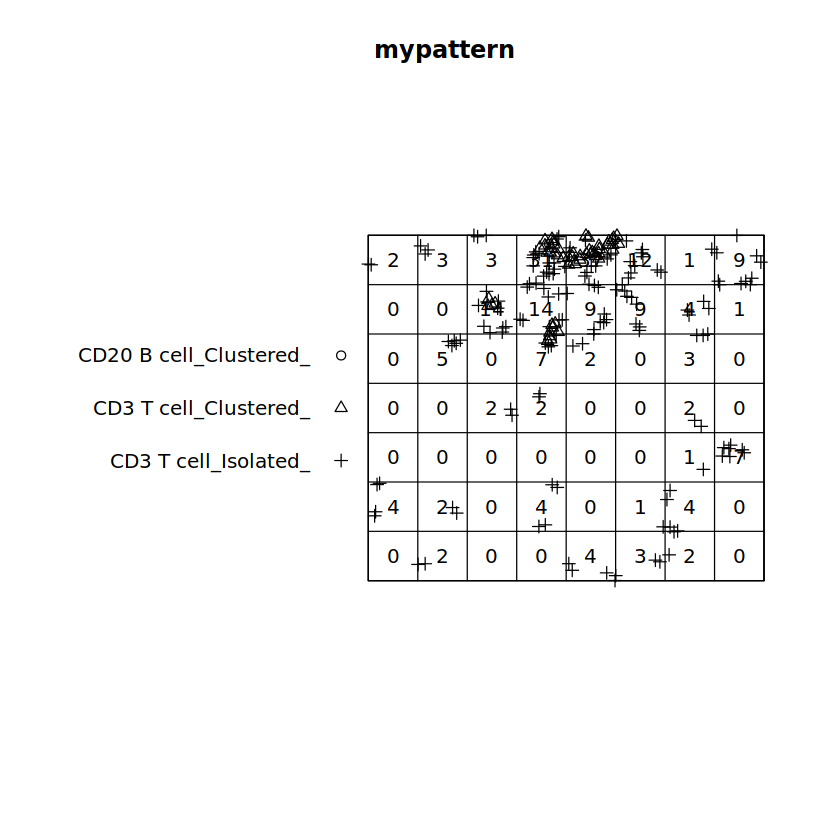

In [31]:
plot(mypattern)
Q <- quadratcount(mypattern, nx=nxny[1], ny=nxny[2])
plot(Q,add=TRUE) 

In [32]:
#### occupancy counts
mydata[,'leiden2'] = sub("$","_",mydata$leiden) #leiden #why?


# loop 
pList = list()
for (s_scene in ls_scene) { #ls_scene[1:18]
  if (file.exists(sprintf("./data/OccLeiden/cycIF_%s_Occ_range.csv",s_scene))){ 
          print('exists skipping')
          next }  
  combined_df_occ <- data.frame(unlist.result_table.=double(),square_len=double(),
                    slide_scene=character())
  print(s_scene)
  s_scene_scene <- str_replace(s_scene, '_scene', '-Scene-')
  #new - use square ROI
  myroiSubset <- myrois[grep(s_scene_scene, myrois$X),]
  ymin <- myroiSubset %>% pull('ymin')
  ymax <- myroiSubset %>% pull('ymax')
  xmin <- myroiSubset %>% pull('xmin')
  xmax <- myroiSubset %>% pull('xmax')
  #make smaller square
  mydataSubset <- mydata[grep(s_scene, mydata$X), c('X','DAPI_X','DAPI_Y','leiden2')]
  mydataSubsetRoi <- filter(mydataSubset, DAPI_X>xmin & DAPI_X<xmax & DAPI_Y>ymin & DAPI_Y<ymax)
  mypattern <- ppp(mydataSubsetRoi[,"DAPI_X"],mydataSubsetRoi[,"DAPI_Y"],c(xmin,xmax),c(ymin,ymax))
  win_p <- mypattern$window
  marks(mypattern) <- factor(mydataSubsetRoi$leiden2)
  for (i in 1: 30) {
      nxny <- makeQuadrats(mypattern,i*10)
        skip_to_next <- FALSE
      tryCatch({
        result_table <- quadratcount.splitppp(split(mypattern), nx=nxny[1], ny=nxny[2])
        counts <- data.frame(unlist(result_table))
          }, error = function(e) { skip_to_next <<- TRUE})
      if(skip_to_next) { 
          print('error. skipping')
          next }
      # result_table <- quadratcount.splitppp(split(mypattern), nx=nxny[1], ny=nxny[2])
      # counts <- data.frame(unlist(result_table))
      if (length(counts) > 0) {
        counts['square_len'] = i*10
        counts['slide_scene'] = s_scene
        combined_df_occ <- rbind(combined_df_occ, counts)
        }
      }
  write.csv(combined_df_occ,sprintf("./data/OccLeiden/cycIF_%s_Occ_range.csv",s_scene), row.names = TRUE)
  }
  #break

# #save out
# error "JP-TMA1-1_scene091"
# s_num = 'ROI'#'inhom' #first
# write.csv(combined_df_occ,sprintf("./data/cycIF_%s_Occ_range.csv",s_num), row.names = TRUE)
print('done')

[1] "JP-TMA2-1_scene01"
[1] "JP-TMA2-1_scene02"
[1] "JP-TMA2-1_scene03"
[1] "JP-TMA2-1_scene04"
[1] "JP-TMA2-1_scene05"
[1] "JP-TMA2-1_scene06"
[1] "JP-TMA2-1_scene07"
[1] "JP-TMA2-1_scene08"
[1] "JP-TMA2-1_scene09"
[1] "JP-TMA2-1_scene10"
[1] "JP-TMA2-1_scene11"
[1] "JP-TMA2-1_scene12"
[1] "JP-TMA2-1_scene13"
[1] "JP-TMA2-1_scene14"
[1] "JP-TMA2-1_scene15"
[1] "JP-TMA2-1_scene17"
[1] "JP-TMA2-1_scene18"
[1] "JP-TMA2-1_scene19"
[1] "JP-TMA2-1_scene20"
[1] "JP-TMA2-1_scene21"
[1] "JP-TMA2-1_scene22"
[1] "JP-TMA2-1_scene23"
[1] "JP-TMA2-1_scene24"
[1] "JP-TMA2-1_scene25"
[1] "JP-TMA2-1_scene26"
[1] "JP-TMA2-1_scene28"
[1] "JP-TMA2-1_scene29"
[1] "JP-TMA2-1_scene30"
[1] "JP-TMA2-1_scene31"
[1] "JP-TMA2-1_scene32"
[1] "JP-TMA2-1_scene33"
[1] "JP-TMA2-1_scene34"
[1] "JP-TMA2-1_scene35"
[1] "JP-TMA2-1_scene36"
[1] "JP-TMA2-1_scene37"
[1] "JP-TMA2-1_scene38"
[1] "JP-TMA2-1_scene39"
[1] "JP-TMA2-1_scene40"
[1] "JP-TMA2-1_scene41"
[1] "JP-TMA2-1_scene42"
[1] "JP-TMA1-1_scene002"
[1] "JP-TMA1-1_

In [ ]:
counts <- read.csv(sprintf("./data/Occ/cycIF_%s_Occ_range.csv",s_scene))
s_scene

In [72]:
count_scene <- dplyr::filter(counts, grepl('CD3 T cell', X))
#boxCounts <- count_scene %>% group_by(square_len) %>% summarise(Counts = sum(unlist.result_table.))
count_scene$occupied <- as.numeric(count_scene$unlist.result_table > 0)
boxcounts <- aggregate(count_scene$occupied, by=list(Category=count_scene$square_len), FUN=sum)

In [73]:
BoxSizes <- seq(10,305,10)
boxCounts <- boxcounts$x
LongSide <- 7000
x <- log(LongSide/BoxSizes)
y <- unlist(log(as.numeric(unlist(boxCounts[1:length(BoxSizes)]))))
OverallSlope <- (lsfit(x, y)$coef[2])

In [74]:
OverallSlope

X 
0.5991438

In [75]:
x

[1] 6.551080 5.857933 5.452468 5.164786 4.941642 4.759321 4.605170 4.471639
 [9] 4.353856 4.248495 4.153185 4.066174 3.986131 3.912023 3.843030 3.778492
[17] 3.717867 3.660709 3.606641 3.555348 3.506558 3.460038 3.415586 3.373027
[25] 3.332205 3.292984 3.255243 3.218876 3.183785 3.149883

In [76]:
y

[1] 5.631212 5.613128 5.537334 5.446737 5.356586 5.298317 5.209486 5.147494
 [9] 5.068904 5.017280 4.934474 4.867534 4.844187 4.779123 4.718499 4.672829
[17] 4.564348 4.543295 4.521789 4.430817 4.356709 4.343805 4.276666 4.189655
[25] 4.127134 4.127134 3.891820 3.891820 3.891820 3.891820

In [77]:
#getDimRangeFromSlope(boxCounts=boxCounts$x, BoxSizes=seq(10,305,10))

## getis ord
https://www.rdocumentation.org/packages/ecespa/versions/1.1-12/topics/getis


Beyond immune density: critical role of spatial heterogeneity in estrogen receptor-negative breast cancer
Sidra Nawaz 1 2 3, Andreas Heindl 1 2 3, Konrad Koelble 4 5, Yinyin Yuan 1 2 3


s=50, 100 or 250 μm.

1.
Cancer hotspot fractional: the fraction of cancer hotspots that are also immune hotspots (fC);

2.
Immune hotspot fractional: the fraction of immune hotspots that are also cancer hotspots (fI); and

3.
Cancer–immune hotspot co-localization: the fractional area of tumor where cancer and immune hotspots were co-localized (fC–I).


second or fourth order

In [20]:
# Given the box counts and the range of box size, determine the fractal
# dimensions at different length scale ranges.
# boxCounts contains integers corresponding to the number of
# boxes needed to cover the cells of interest at a given box size.
getDimRangeFromSlope <- function(boxCounts, BoxSizes=seq(10,600,5)) {
  # Overall constant to scale the x-axis.
  LongSide <- 7000
  
  if(length(boxCounts) != length(BoxSizes)) {
    print(length(boxCounts))
    print(length(BoxSizes))
    stop("Vector lengths do not match")
  }
  
  if (length(boxCounts[boxCounts<=1])>2 ) {
    res=data.frame(t(rep(0,8)))
    colnames(res) <- c("Small", "Overall", "Large", "Slope_50_100", "Slope_50_200",
                       "Slope_20_80", "Slope_10_80", "Slope_10_40")
    return(res)
  }
  
  x0 <- 1/BoxSizes
  x <- log(LongSide/BoxSizes)
  y <- unlist(log(as.numeric(unlist(boxCounts[1:length(BoxSizes)]))))
  
  #print(rbind(x,y))
  
  if(sum(is.infinite(y)) > 0) {
    warning("Inf replaced with 0")
  }
  
  y[is.infinite(y)] = 0
  
  l <- length(BoxSizes)
  dl <- 80
  
  OverallSlope <- (lsfit(x, y)$coef[2])
  SmallSlope <- lsfit(x[1:2], y[1:2])$coef[2] # 10 to 15
  LargeSlope <- lsfit(x[abs(l-dl):l], y[abs(l-dl):l])$coef[2] # 200 to 600
  
  Slope_50_100 <- lsfit(x[9:19], y[9:19])$coef[2]
  Slope_50_200 <- lsfit(x[9:29], y[9:29])$coef[2]
  Slope_20_80 <- lsfit(x[3:15], y[3:15])$coef[2]
  Slope_10_80 <- lsfit(x[1:15], y[1:15])$coef[2]
  Slope_10_40 <- lsfit(x[1:7], y[1:7])$coef[2]
  
  res <- data.frame(SmallSlope, OverallSlope, LargeSlope, Slope_50_100, Slope_50_200,
                    Slope_20_80, Slope_10_80, Slope_10_40)
  colnames(res) <- c("Small", "Overall", "Large", "Slope_50_100", "Slope_50_200",
                     "Slope_20_80", "Slope_10_80", "Slope_10_40")
  return(res)
}


In [18]:
#shared code
#filter(df, gender == 'M' & id >11)
# Return occupancies and box counts for a list of point patterns
# (spatstat class ppp).
# typesToCount is the phenotype of interest,
# categoriesToCount is the tissue type of interest (e.g., cancer, stroma).
OccsAndCountsPatternList <- function(pList, typesToCount=NULL,
                                     categoriesToCount="All") {
  require(spatstat)
  require(gtools)
  require(pbapply)
  
  OccsCounts <- lapply(pList, function(x){
    getBoxOccsAndCounts(x, typesToCount=typesToCount,
                        categoriesToCount=categoriesToCount)
  })
  
  return(OccsCounts)
}

# Return occupancies and box counts for a single point pattern
# (spatstat class ppp).
# countSizes is the range of box sizes in microns.
# Result is a data frame where each column corresponds to one box size,
# row 1 contains the occupancies (value between 0 and 1),
# and row 2 contains the box counts (integer).
# For fractal dimension at different ranges, call getDimRangeFromSlope
# on the box counts (row 2 of the result).
getBoxOccsAndCounts <- function(p, countSizes=seq(10,600,5),
                                typesToCount=NULL,
                                categoriesToCount="All", thin=NULL) {
  require(pbapply)
  require(spatstat)
  
  print("in gBOAC")
  
  if (!is.null(thin)) {
    p <- randomThinPheno(p, x=thin, typesToCount=typesToCount)
  }
  
  counts <- pblapply(countSizes, function(x){
    res=chopToQuadratsBoth(p, x, typesToCount,
                           categoriesToCount);
    return(res)
  })
  
  counts <- data.frame(matrix(unlist(counts), nrow=2))
  colnames(counts) <- as.character(countSizes)
  
  return(counts)
}


# Performs a quadrat count of the given point pattern with a given
# quadrat size.
chopToQuadratsBoth <- function(p, squareLength=60, typesToCount=NULL,
                               categoriesToCount="All",
                               thinFactor=NULL) {
  require(spatstat)
  require(spatstat.utils)
  require(pbapply)
  
  xmin <- Window(p)$xrange[1]
  xmax <- Window(p)$xrange[2]
  ymin <- Window(p)$yrange[1]
  ymax <- Window(p)$yrange[2]
  dx <- xmax-xmin
  dy <- ymax-ymin
  
  dxTrunc <- 2*squareLength * as.integer(dx / (2*squareLength))
  dyTrunc <- 2*squareLength * as.integer(dy / (2*squareLength))
  
  #print(paste("Total cells: ", p$n))
  
  p <- p[owin(c(xmin, xmin+dxTrunc),c(ymin,ymin+dyTrunc))]
  
  pOrig <- p
  
  if (categoriesToCount=="Tumor" | categoriesToCount=="Cancer" |
      categoriesToCount == "Epithelial")
    p <- subset(p, Tissue.Category %in% list("Tumor", "CancerIsland",
                                             "CancerIslands",
                                             "Cancer Islands",
                                             "epithelial",
                                             "Epithelial", "Epithelium",
                                             "Cancer", "cancer island"))
  else if (categoriesToCount=="Stroma")
    p <- subset(p, Tissue.Category %in% list("Stroma",
                                             "stroma",
                                             "Epithelial associated"))
  
  pSubset <- p
  
  # Keep only the cells of the types we're interested in.
  if (!is.null(typesToCount) & is.null(thinFactor)) {
    pSubset <- subset(p, select=Phenotype)
    pSubset <- subset(pSubset, marks %in% typesToCount)
    #print(paste("After cell filtering: ", pSubset$n))
  }
  if (!is.null(thinFactor) & is.null(typesToCount)) {
    pSubset <- randomThin(pSubset, thinFactor)
    #print(paste("After thinning (no filtering): ", pSubset$n))
  }
  
  # Split the starting pattern into smaller squares.
  # There must be a way to avoid doing this twice.
  # Why would masterCounts have a different length than allCellsCounts here?
  #print("Splitting into squares")
  #masterCounts <- parallelQuad(pSubset, squareLength)
  
  masterCounts <- makeQuadrats(pSubset, squareLength)
  # Split the original pattern (all cell types) into smaller squares.
  #allCellsCounts <- parallelQuad(pOrig, squareLength)
  allCellsCounts <- makeQuadrats(pOrig, squareLength)
  
  #print("Quadrats made.")
  
  # Note which ones are empty.
  toKeep <- sapply(allCellsCounts, function(x){x!=0})
  #print(paste("Omitting", length(toKeep)-sum(toKeep), "of", length(toKeep)))
  #print(paste("Before subsetting:", length(masterCounts), length(allCellsCounts)))
  
  # Get rid of squares corresponding to no tissue.  
  allCellsCounts <- subset(allCellsCounts, toKeep)
  masterCounts <- masterCounts[toKeep]  
  #print(paste("After subsetting:", length(masterCounts), length(allCellsCounts)))
  # If there isn't a valid matrix, put in an empty one.
  
  # Make the counts binary: 1 if there's at least one cell of interest, 0 if not.
  #print("Binarizing grid counts")
  squareCounts <- lapply(masterCounts, function(x){ifelse(x>=1,1,0)})
  squareCounts <- unlist(squareCounts)
  
  return(c(sum(squareCounts)/length(squareCounts), sum(squareCounts)))
  
}

# Create quadrats given a point pattern and a square size.
makeQuadrats <- function(p, squareLength) {
  require(spatstat)
  require(pbapply)
  
  dx <- Window(p)$xrange[2] - Window(p)$xrange[1]
  dy <- Window(p)$yrange[2] - Window(p)$yrange[1]
  
  nx <- floor(dx/squareLength)
  ny <- floor(dy/squareLength)
  
  # Delete a point for potential edge case.
  if (max(p$y) - Window(p)$yrange[2] < 1e-10) {
    #print("edge case detected")
    #print(paste(max(p$y), Window(p)$yrange[2], max(p$y)-Window(p)$yrange[2]))
    p <- subset(p, y<max(p$y))
    #print(max(p$y))
  }
  
  #print(paste(max(p$x), Window(p)$xrange[2], max(p$x)-Window(p)$xrange[2]))
  if (max(p$x) - Window(p)$xrange[2] < 1e-10) {
    #print("edge case detected")
    #print(paste(max(p$x), Window(p)$xrange[2], max(p$x)-Window(p)$xrange[2]))
    p <- subset(p, x<max(p$x))
    #print(max(p$x))
  }
  
  #print(paste(squareLength, ": Splitting", p$n, "points into", nx, "by",
  # ny, "quadrats"))
  
  # If there are too few points, quadratcount.ppp can give an error:
  # Error in table(list(y=yg, x=xg)): all arguments must have the same length
  if (p$n > 0) {
    patternList <-quadratcount.ppp(p, nx, ny)
    #print("Counted")
    #print(length(unlist(patternList, recursive=TRUE)))
    patternList<-unlist(patternList, recursive=FALSE)
  }
  
  else(patternList <- rep(0, nx*ny))
  
  return(patternList)  
}

# Given the box counts and the range of box size, determine the fractal
# dimensions at different length scale ranges.
# boxCounts contains integers corresponding to the number of
# boxes needed to cover the cells of interest at a given box size.
getDimRangeFromSlope <- function(boxCounts, BoxSizes=seq(10,600,5)) {
  # Overall constant to scale the x-axis.
  LongSide <- 7000
  
  if(length(boxCounts) != length(BoxSizes)) {
    print(length(boxCounts))
    print(length(BoxSizes))
    stop("Vector lengths do not match")
  }
  
  if (length(boxCounts[boxCounts<=1])>2 ) {
    res=data.frame(t(rep(0,8)))
    colnames(res) <- c("Small", "Overall", "Large", "Slope_50_100", "Slope_50_200",
                       "Slope_20_80", "Slope_10_80", "Slope_10_40")
    return(res)
  }
  
  x0 <- 1/BoxSizes
  x <- log(LongSide/BoxSizes)
  y <- unlist(log(as.numeric(unlist(boxCounts[1:length(BoxSizes)]))))
  
  #print(rbind(x,y))
  
  if(sum(is.infinite(y)) > 0) {
    warning("Inf replaced with 0")
  }
  
  y[is.infinite(y)] = 0
  
  l <- length(BoxSizes)
  dl <- 80
  
  OverallSlope <- (lsfit(x, y)$coef[2])
  SmallSlope <- lsfit(x[1:2], y[1:2])$coef[2] # 10 to 15
  LargeSlope <- lsfit(x[abs(l-dl):l], y[abs(l-dl):l])$coef[2] # 200 to 600
  
  Slope_50_100 <- lsfit(x[9:19], y[9:19])$coef[2]
  Slope_50_200 <- lsfit(x[9:29], y[9:29])$coef[2]
  Slope_20_80 <- lsfit(x[3:15], y[3:15])$coef[2]
  Slope_10_80 <- lsfit(x[1:15], y[1:15])$coef[2]
  Slope_10_40 <- lsfit(x[1:7], y[1:7])$coef[2]
  
  res <- data.frame(SmallSlope, OverallSlope, LargeSlope, Slope_50_100, Slope_50_200,
                    Slope_20_80, Slope_10_80, Slope_10_40)
  colnames(res) <- c("Small", "Overall", "Large", "Slope_50_100", "Slope_50_200",
                     "Slope_20_80", "Slope_10_80", "Slope_10_40")
  return(res)
}

# Thin points of a particular phenotype by a factor of x.
# Points of other phenotypes will be unaffected.
randomThinPheno <- function(p, x=0.5, typesToCount=list("CD20+")) {
  pSubset <- subset(p, select=Phenotype)
  irrelevantPheno <- !(pSubset$marks %in% typesToCount)
  
  retain <- (runif(npoints(pSubset)) < x | irrelevantPheno )
  res <- p[retain]
  return(res)
}